# Blackjack's using Monte Carlo approaches - work in progress

Monte Carlo approaches are a kind of reinforcement learning (RL) that do not require to have a a complete model to work with. They can learn from past experience without knowing the transition probabilities of the model, differently from dynamic programming.

The main idea is that Monte Carlo approaches work by averaging the returns recived during an episode, so the value function and the policy are only changed at the end of each eposide. Depending on how we use the states to evaluate the policy we differentiate:
 * First-visit methods: they average the returns recieved after the first time a state is visited in an episode.
 * Every-visit methods: they average the returns recivied after every time a state is visited in an episode.

Althought first-visit methods uses less information available, they capture unbiased returns with very little variance and therefore usually converge faster than every-visit methods.


As DP methods, MC methods can also use general policy iteration (GPI) to find the optimal policy and its optimal value function. 

We will use first-visit Monte Carlo approaches to estimate the value function of the possible states of the Vlackjack card game. A summarized set of rules follows.

 - The goal is to reach a sum of cars that adds up to as close to 21 as possible without exceeding it.
 - All face cards count as 10 except for the ace, which can count as either 1 or 11, whathever is best.
 - Both player and dealer start with two cards.
 - The dealer starts with one card face up and the other down.
 - If the player starts with exactly 21 he immediately wins the game if the dealer doesn't have already 21, in which case they draw.
 - The firs player can ask for more cards until he decides to stop (sticks) or exeeds 21 and loses (goes bust).
 - The dealer always sticks with a sum of 17 or greater and takes cards otherwise. 

### V(s) estimation for a particular policy using first-visit Monte Carlo approach

Assumptions:
 - Each game is an episode which yields +1 or -1 depending on whether the player wins or loses, respectively.
 - Assume non-discounting ($\gamma$ = 1)
 - Players actions A are hit or miss.
 - The deck has replacement (infinite number of any card).
 - The three variables that control the game are the current sum (12-21), the dealer's showing card (ace-10) and whether or not the player holds a usable ace.
 - As any state cannot be revisited again, this problems holds no difference between applying first or every-visit MC methods. 

The polociy to be evaluated is sticking only with a sum of 20 or 21 and hit otherwise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [493]:
def initialization():
    pi = np.zeros([2, 22, 22], dtype=np.int8)
    V = np.zeros([2, 22, 22])
    R = np.zeros([2,10,10])
    Q = np.zeros([2, 22, 22,2])
    return pi, V, R, Q

In [315]:
pi, V, R, Q = initialization()

In [4]:
def draw_card():
    """Draws a card from a deck with replacement"""
    return random.choice([2,3,4,5,6,7,8,9,10,11])

def compute_state(dealers, players):
    """
    Computes the state of the game using the dealer's and player's cards.
    """
    state = []
    if 11 in players:
        state.append(1)
    else:
        state.append(0)
    state.append(optimal_sum(players))
    state.append(dealers[0])
    return state

def check_winning(dealers, players):
    """
    Computes whether the game has finished or not and the reward.
    """
    players_sum = optimal_sum(players)
    dealers_sum = optimal_sum(dealers)
    if players_sum > 21: #and 11 not in players) or (players_sum > 31 and 11 in players):
        return -1
    elif dealers_sum > 21: #(dealers_sum > 21 and 11 not in dealers) or (dealers_sum > 31 and 11 in dealers):
        return 1
    elif players_sum == 21: #or (players_sum == 31 and 11 in players):
        if dealers_sum == 21: #dealers_sum == 21 or (dealers_sum == 31 and 11 in dealers): # Both players winning
            return 0
        else:
            return 1
    elif dealers_sum == 21:
        return -1
    return 0
    
def check_winner(dealers, players):
    """
    If neither player or dealers have a reached or exceeded 21, computes who is closer.
    """
    players_sum = sum(players)
    dealers_sum = sum(dealers)
    while players_sum > 21:
        players_sum -= 10
    while dealers_sum > 21:
        dealers_sum -= 10
    if players_sum > dealers_sum:
        return 1
    elif players_sum < dealers_sum:
        return -1
    elif players_sum == dealers_sum:
        return 0

In [5]:
def optimal_sum(cards):
    if sum(cards) < 22:
        return sum(cards)
    else:
        for i in range(1,cards.count(11)+1):
            csum = sum(cards) - 10*i
            if (csum < 22):
                return csum
    return sum(cards)

In [6]:
def generate_episode(pi):
    states = []
    rewards = []
    dealers = [draw_card(), draw_card()]
    players = [draw_card(), draw_card()]
    states.append(compute_state(dealers, players))
    if optimal_sum(players) == 21:
        rewards.append(check_winning(dealers, players))
        return (states, rewards)
    else:
        rewards.append(0)
    while optimal_sum(players) < 20:
        players.append(draw_card())
        states.append(compute_state(dealers, players))
        rewards.append(check_winning(dealers, players))
    while sum(dealers) < 17 and abs(rewards[-1]) != 1:
        dealers.append(draw_card())
        states.append(compute_state(dealers, players))
        rewards.append(check_winning(dealers, players))
    if abs(rewards[-1]) != 1:
        rewards.append(check_winner(dealers, players))
    return (states, rewards)
    

In [7]:
def compute_cumulative_reward(rewards, gamma):
    """
    Computes the predicted cumulative rewards of each position so we don't have to navigate the whole array each time 
    we want to compute it for a new state.
    """
    cumulative_reward = [(x*gamma**i) for i, x in enumerate(rewards)]
    csum = sum(cumulative_reward)
    for i, reward in enumerate(cumulative_reward):
        cumulative_reward[i] = csum
        csum = csum - reward
    return cumulative_reward

In [8]:
def policy_evaluation(pi, episodes):
    gamma = 1
    times_seen_state = np.zeros([2, 22,22])
    for _ in range(0, episodes + 1):
        episode = generate_episode(pi)
        cumulative_reward = compute_cumulative_reward(episode[1],1)
        for state, reward, i in zip(episode[0], episode[1], range(len(episode))):
            if state[1] > 21 or state[1] < 12:
                continue #Non reachable state (is terminal one or arbitrary one, like less than 12)
            G = cumulative_reward[i]
            V[tuple(state)] = (V[tuple(state)]*times_seen_state[tuple(state)] + G)/(times_seen_state[tuple(state)] + 1)
            times_seen_state[tuple(state)] += 1
    return V

In [9]:
V = policy_evaluation('pi', 500000)

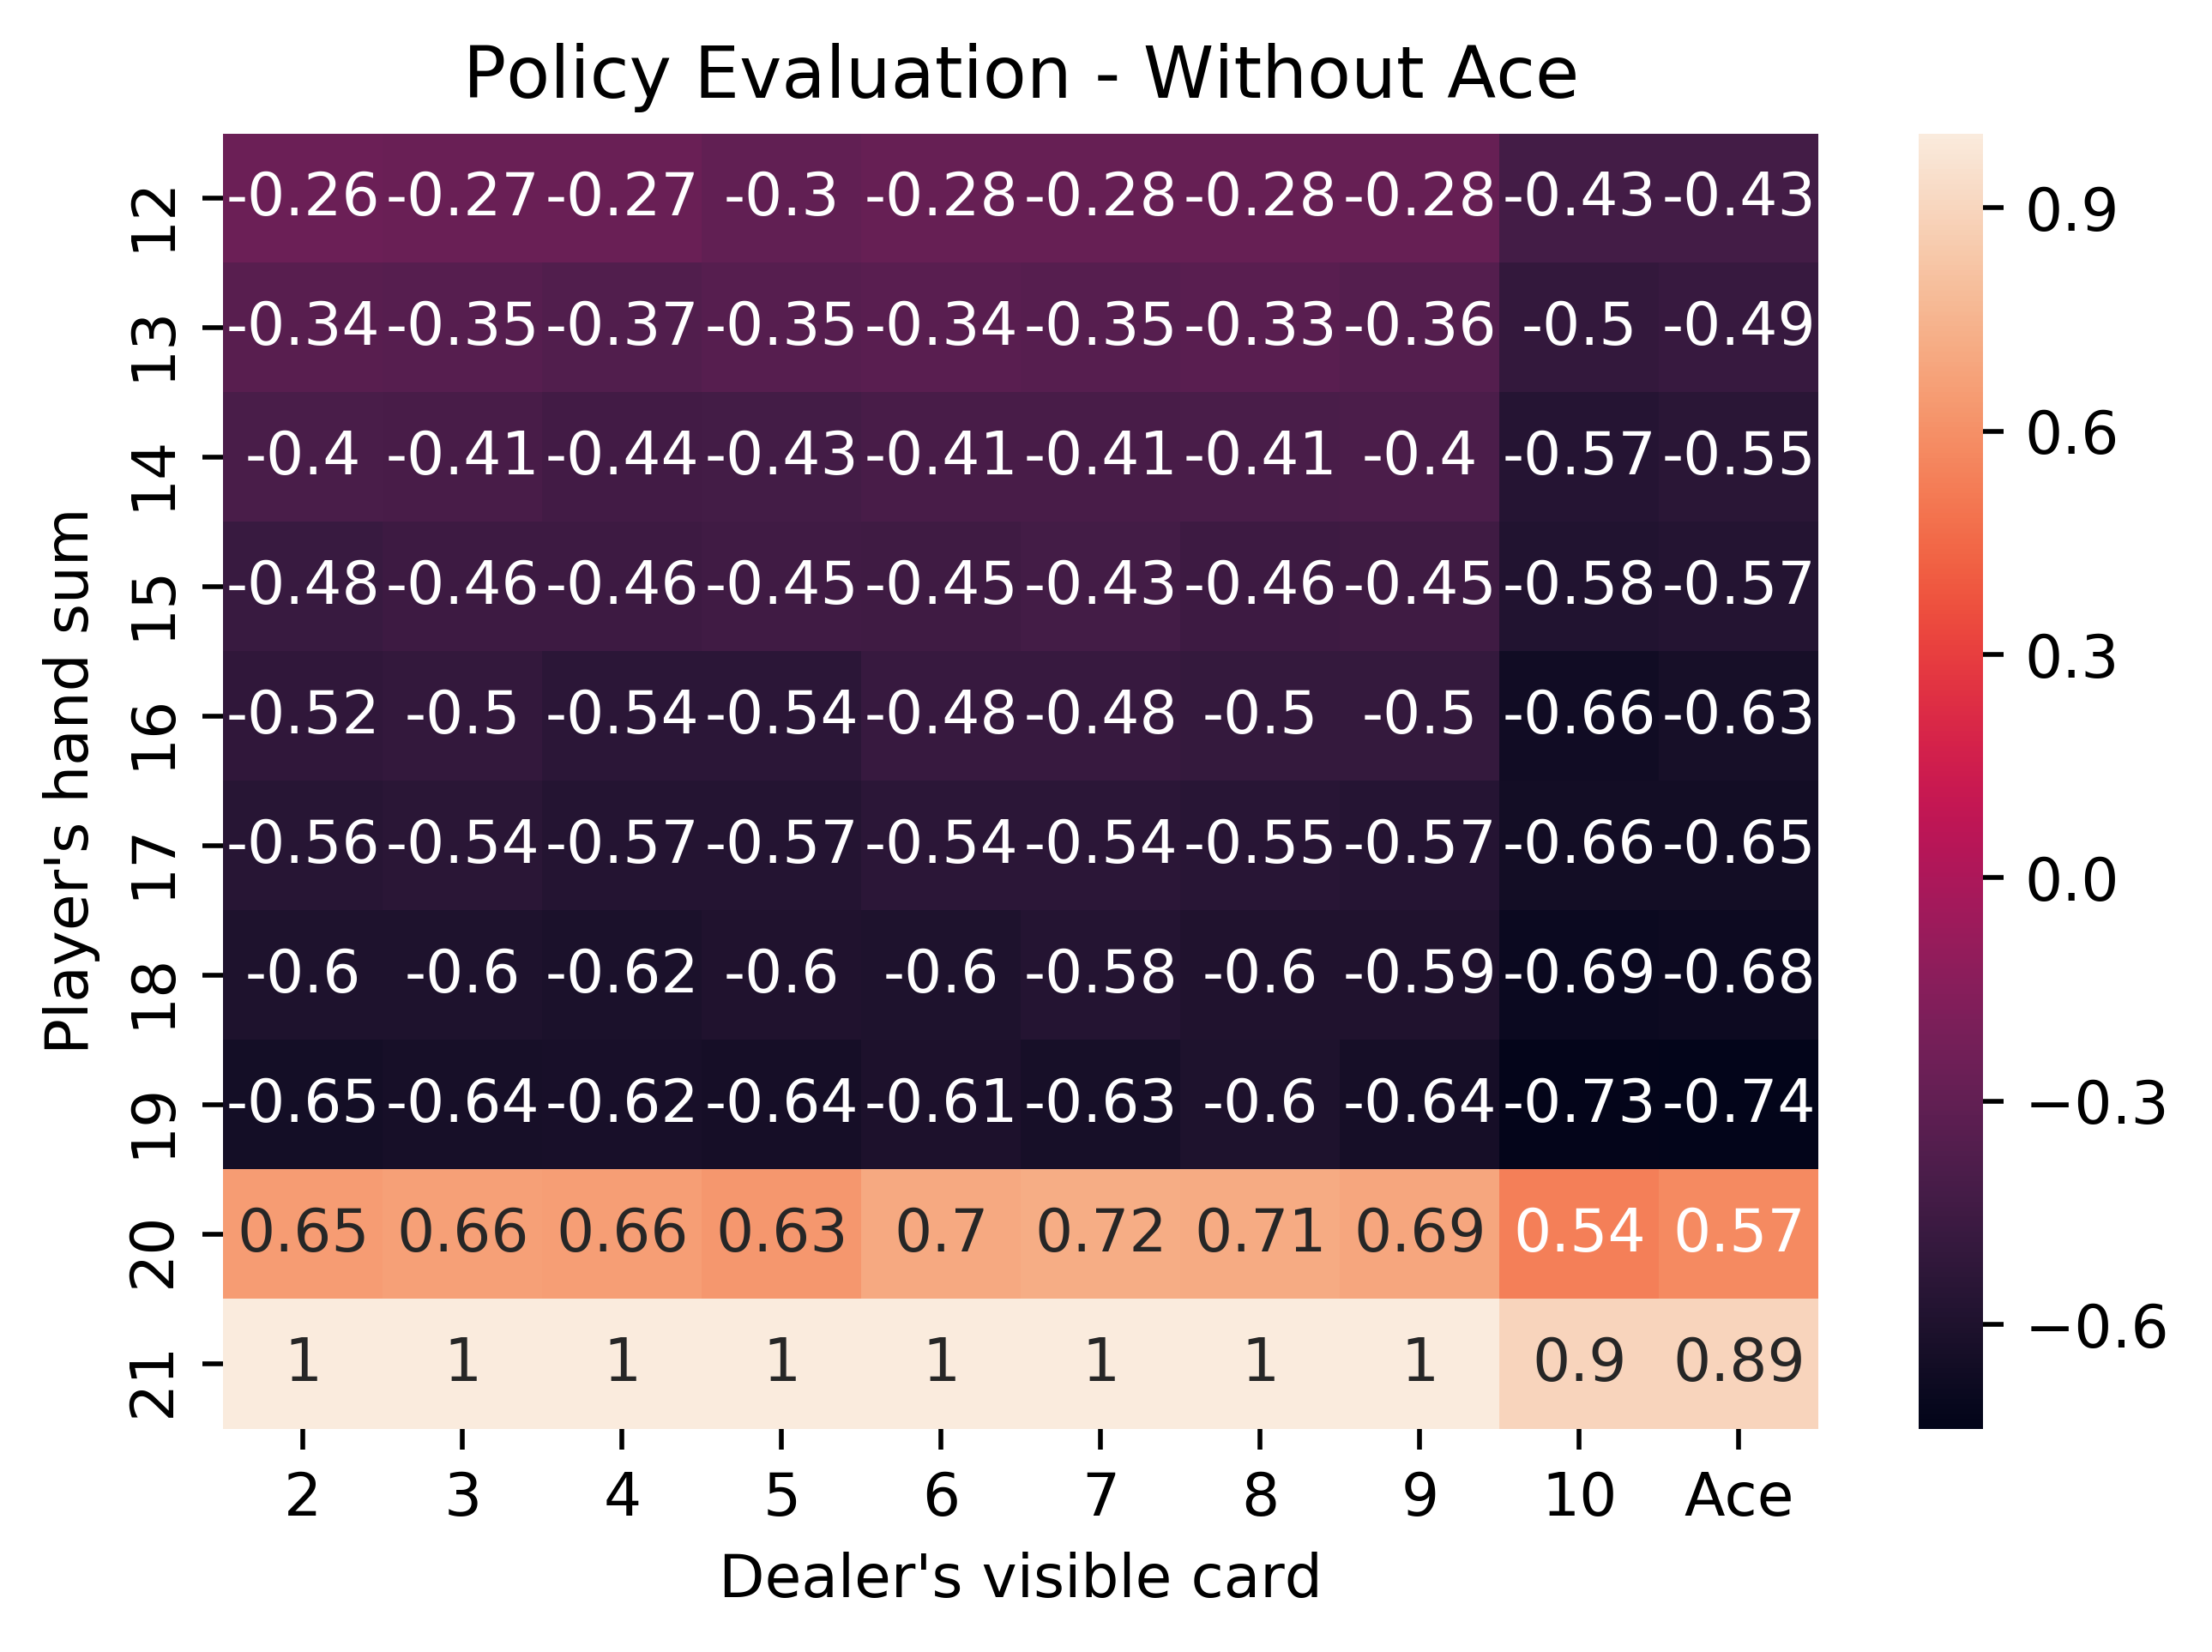

In [10]:
plt.subplots(dpi = 500)
plot = sns.heatmap(V[0][12:22,2:12], xticklabels = [2,3,4,5,6,7,8,9,10,'Ace'], yticklabels=list(range(12, 22)), annot = True)
plt.title('Policy Evaluation - Without Ace')
plt.xlabel('Dealer\'s visible card')
plt.ylabel('Player\'s hand sum')
plt.show()

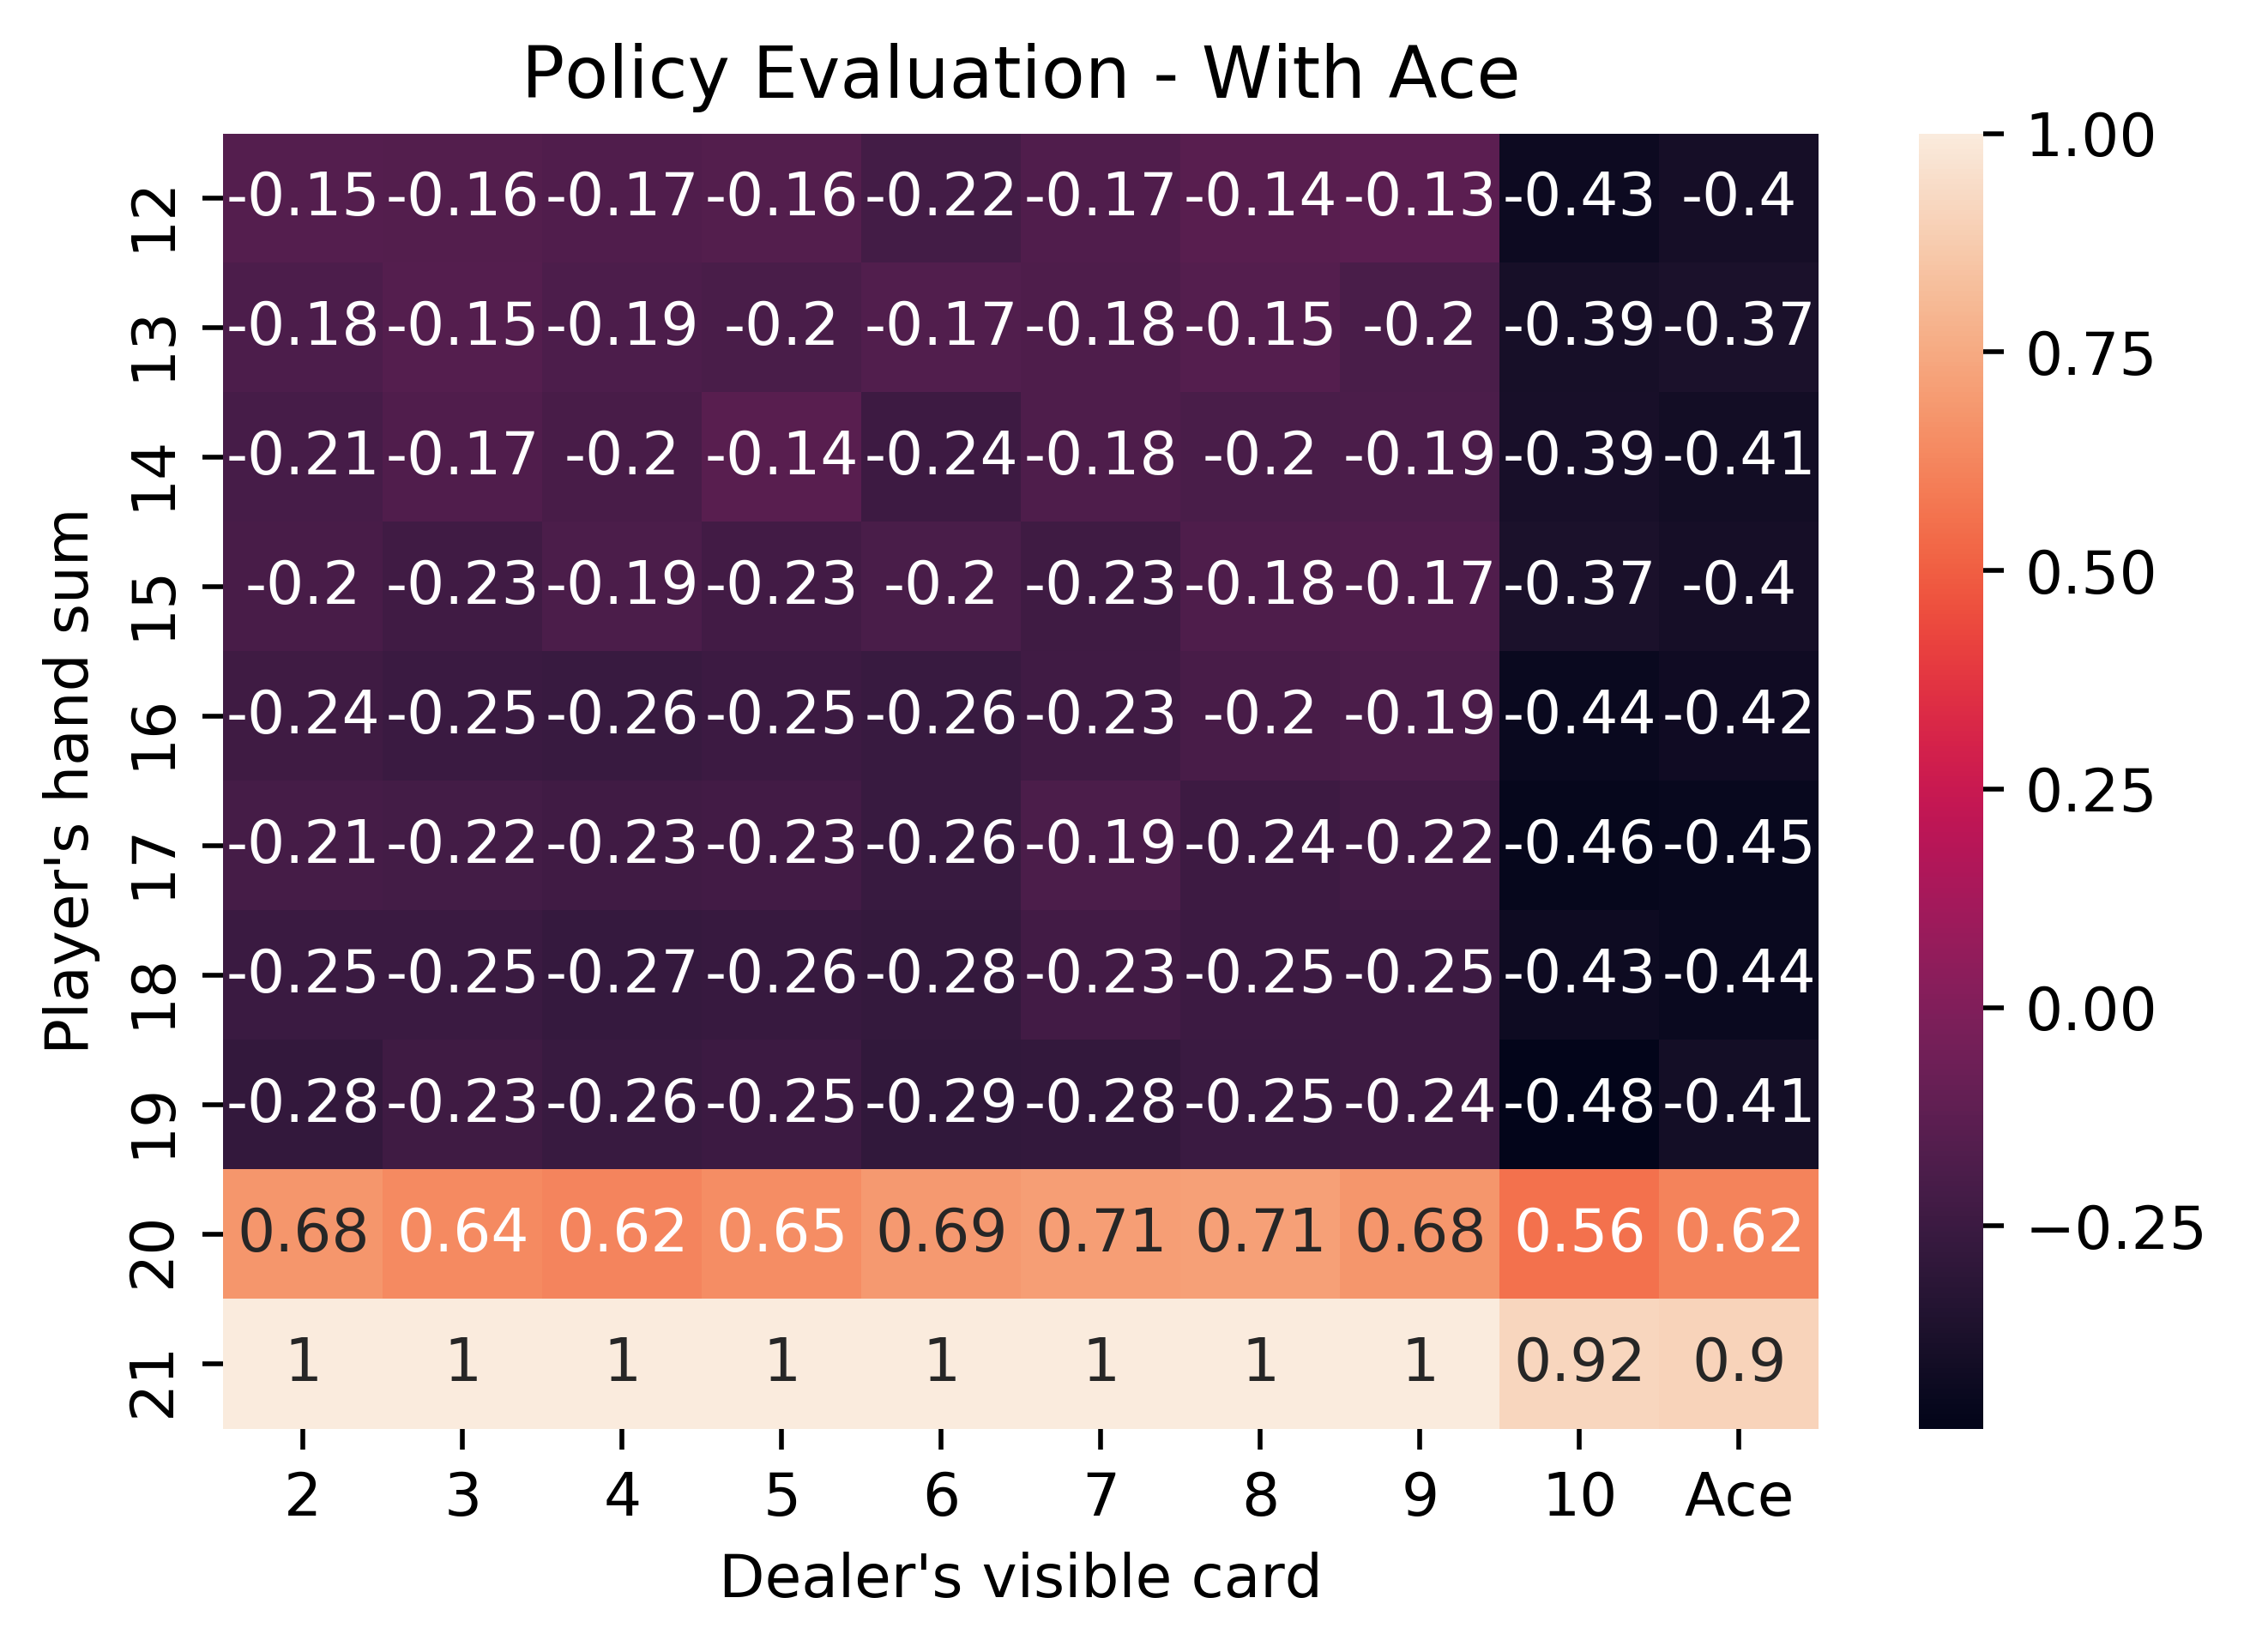

In [11]:
plt.subplots(dpi = 500)
plot = sns.heatmap(V[1][12:22,2:12], xticklabels = [2,3,4,5,6,7,8,9,10,'Ace'], yticklabels=list(range(12, 22)), annot = True)
plt.title('Policy Evaluation - With Ace')
plt.xlabel('Dealer\'s visible card')
plt.ylabel('Player\'s hand sum')
plt.show()

We can that we are usually at a disadvantage in comparision with the dealer. And with this simplistic policy can only expect to win consistently if we hit a 20 or 21. Nevertheless, having an ace improves the chance of not going busting with the next card, as expected. Finially, not even a 21 ensures a victory, as the dealer my also have one. 

## Monte Carlo control with exploring starts

Now we will use a Monte Carlo approximation to control, that is, approximate the optimal policy. To do so, we can follow the same strategy as that dynamic programming uses, the general policy iteration (GPI). GPI consists on iteratively evaluate a policy to infer its optimal value function and then improve the policy with respect to the value function. Doing so iteratively converges with the optimal policy given enought iteartions.

In this case, as we don't have a perfect model to evaluate, we must use action values (q) instead of state values (v). Therefore, the pipeline can be summarised as follows:

$$\pi_0 \xrightarrow{E} q_(\pi_0) \xrightarrow{I} \pi_1\xrightarrow{E} q_(\pi_1) \xrightarrow{I} \pi_2 \xrightarrow{E} ... \xrightarrow{I} \pi_*\xrightarrow{E} q_(\pi_*)  $$

Where $\pi_0$ is any arbitrary policy.

Policy evaluation is done by observing the past experience and averaging the returns, as we did in the previous example. 
In contrast, policy improvement is calculated by making the policy $\pi$ greedy with respect to $q_\pi$. More formally:
$$\pi(s) = arg\max_a q(s,a)$$

Although policy improvement guarantees convergence, it does so over an infinite number of steps, which is usually not managable. We have two options to adress this problem:
 - Keeping track on how the action-values are changing and stop when they change little.
 - Imitate the value iteration method of DP and do only one iteration at each improvement step, which usually works. Furthermore, as MC problems have a episodic-like format, this strategy is very easy and natural to implement.

Other problem that we face because of the absense of a model, infering $\pi$ greedely could potentially lead to sub-optimal results if some actions have not been explored. There are several ways to try to fix the problem. The most easy and naïve is the **exploring starts strategy**. This strategy consists that the first pair of action and state that starts the episode is taken at random with equal probabily and then the environment works as usually. Althought this ensures that all state-action pairs are going to be explored, if we can't control the environtment to do so, it doesn't work. 

We will adapt the code above to try to find the optimal policy using MC control with exploring starts.

In [318]:
def generate_episode_with_random_start(pi):
    rewards = []
    states = []
    actions = []
    random_initial = [random.choice([0,1]), random.choice(range(12, 22)), random.choice(range(2, 12))]
    states.append(random_initial)
    dealers = [random_initial[2], draw_card()]
    if random_initial[0]==1:
        if random_initial[1] == 12:
            players = [11, 11]
        else:
            players = [11, random_initial[1]-11]
    else:
        if random_initial[1]%2 == 0:
            players = [random_initial[1]//2, random_initial[1]//2]
        else:
            players = [random_initial[1]//2, random_initial[1]//2+1]
    if optimal_sum(players) == 21:
        rewards.append(check_winning(dealers, players))
        return (states, rewards, [0])
    else:
        rewards.append(0)
    take_card = random.choice([0,1]) #Exploring states condition of random action to start.
    actions.append(take_card)
    while take_card:
        players.append(draw_card())
        states.append(compute_state(dealers, players))
        if optimal_sum(players) < 21:
            take_card = pi[tuple(states[-1])]
        else:
            take_card = 0
        rewards.append(check_winning(dealers, players))
        actions.append(take_card)
    while sum(dealers) < 17 and abs(rewards[-1]) != 1:
        dealers.append(draw_card())
        states.append(compute_state(dealers, players))
        rewards.append(check_winning(dealers, players))
    if abs(rewards[-1]) != 1:
        rewards.append(check_winner(dealers, players))
    return (states, rewards, actions)

In [500]:
pi, V, R, Q = initialization()

In [501]:
def policy_evaluation_and_improvement_with_exploring_states(pi, episodes, Q):
    gamma = 1
    times_seen_state = np.zeros([2,22,22,2])
    for _ in range(0, episodes + 1):
        episode = generate_episode_with_random_start(pi)
        cumulative_reward = compute_cumulative_reward(episode[1],1)
        for i in range(0,len(episode[2])):
            state = episode[0][i]
            reward = episode[1][i]
            action = episode[2][i]
            if state[1] > 21 or state[1] < 12:
                continue #Non reachable state (is terminal one or arbitrary one, like less than 12)
            G = cumulative_reward[i]
            Q[tuple(state)][action] = (Q[tuple(state)][action]*times_seen_state[tuple(state)][action] + G)/(times_seen_state[tuple(state)][action] + 1)
            times_seen_state[tuple(state)][action] += 1
        for state, action in zip(episode[0], episode[2]):
            if state[1] > 21:
                continue
            else:
                pi[tuple(state)] = Q[tuple(state)].argmax()
    return Q, pi

In [502]:
Q,pi = policy_evaluation_and_improvement_with_exploring_states(pi, 1000000, Q)

In [510]:
Q[0][17]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.21837273, -0.38611844],
       [-0.20222624, -0.38041378],
       [-0.17665597, -0.37570236],
       [-0.1573268 , -0.37877944],
       [-0.13758296, -0.37410101],
       [-0.21177879, -0.36338645],
       [-0.28254164, -0.37211803],
       [-0.33307038, -0.39052045],
       [-0.40375056, -0.43815154],
       [-0.28893569, -0.42920159],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

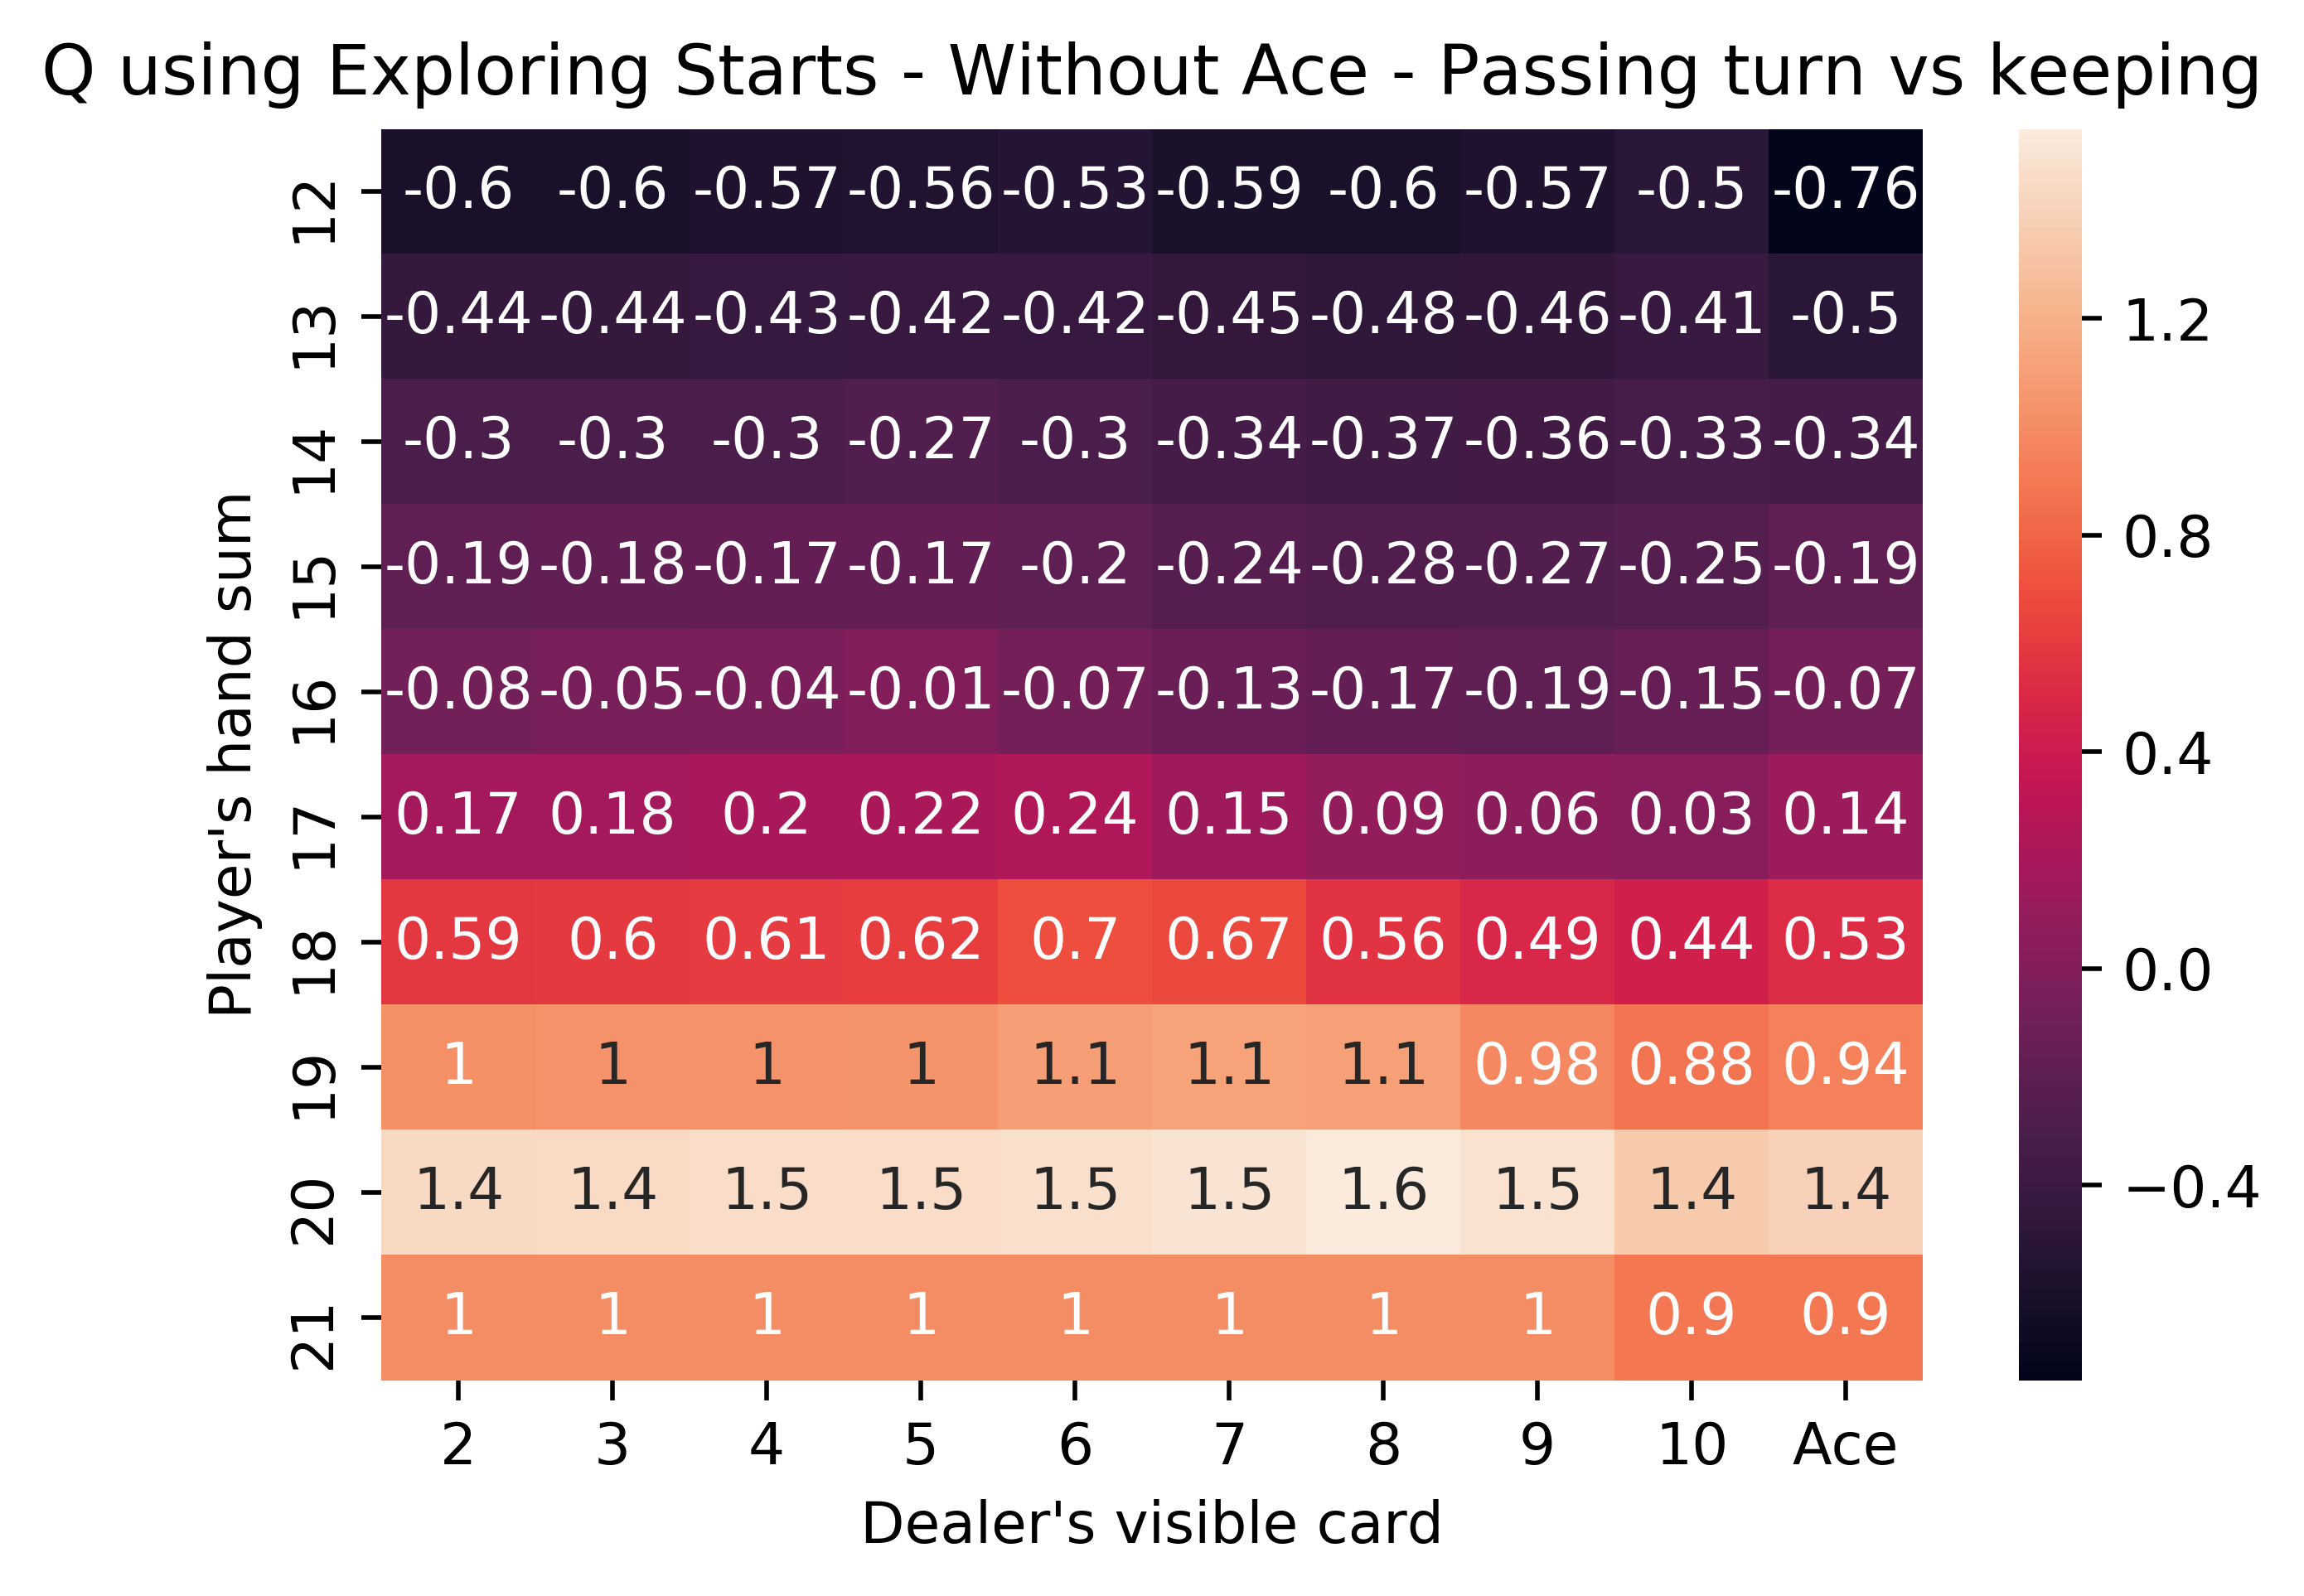

In [503]:
plt.subplots(dpi = 500)
plot = sns.heatmap((Q[0][12:22,2:12,0] - Q[0][12:22,2:12,1]).round(2), xticklabels = [2,3,4,5,6,7,8,9,10,'Ace'], yticklabels=list(range(12, 22)), annot = True)
plt.title('Q using Exploring Starts - Without Ace - Passing turn vs keeping')
plt.xlabel('Dealer\'s visible card')
plt.ylabel('Player\'s hand sum')
plt.show()

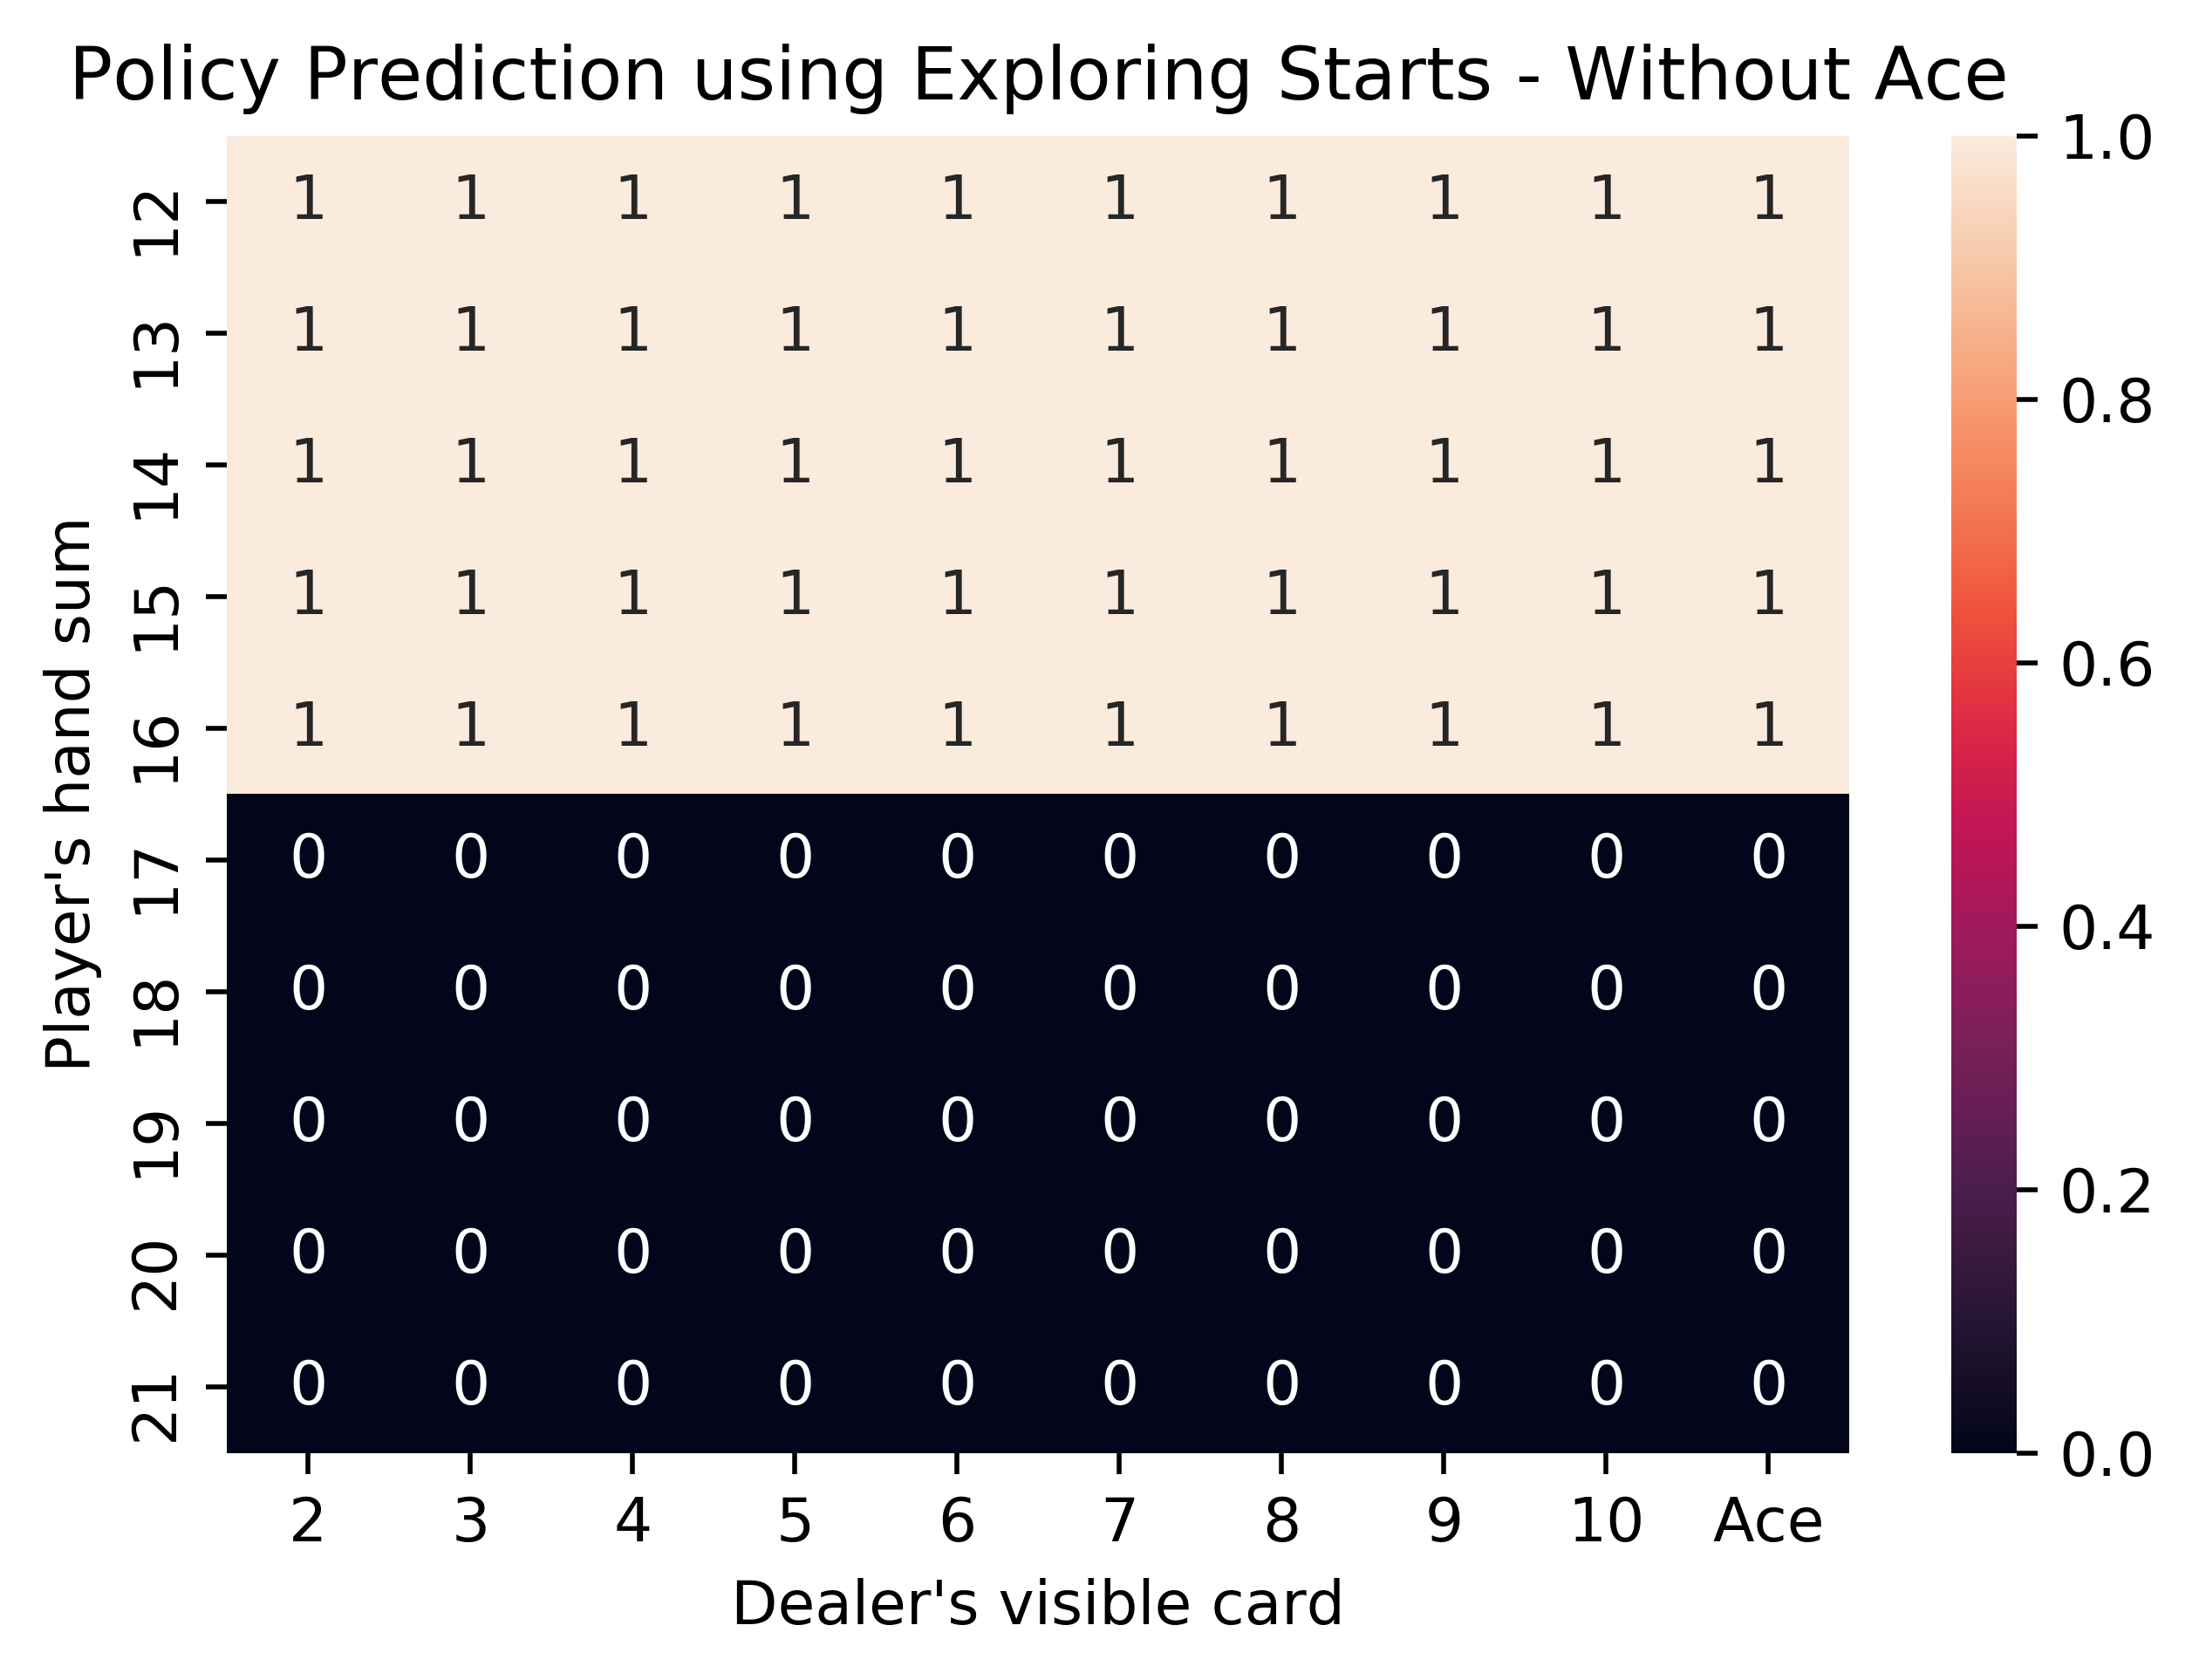

In [505]:
plt.subplots(dpi = 500)
plot = sns.heatmap(pi[0][12:22,2:12], xticklabels = [2,3,4,5,6,7,8,9,10,'Ace'], yticklabels=list(range(12, 22)), annot = True)
plt.title('Policy Prediction using Exploring Starts - Without Ace')
plt.xlabel('Dealer\'s visible card')
plt.ylabel('Player\'s hand sum')
plt.show()